<a href="https://colab.research.google.com/github/Nekoiii/ML_Practices_colab/blob/main/launch_sd_with_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://qiita.com/nR9h3kLy/items/a2d2be4c48f253a8e331
https://qiita.com/Limitex/items/275d91dd4acdbf57b5f4


StableDiffusionPipeline详细原理解说：https://happy-shibusawake.com/sd-pipeline_txt2img/948/

In [ ]:
!git clone https://github.com/cloneofsimo/lora.git
!pip install accelerate==0.19.0 bitsandbytes
%cd lora
!pip install .
!pip install -r requirements.txt

In [ ]:
%%script false --no-raise-error
!git clone https://github.com/huggingface/diffusers.git -b v0.14.0
%cd diffusers
!pip install .
%cd ../

In [ ]:
%%script false --no-raise-error
!git clone https://github.com/huggingface/transformers -b v4.30.0
%cd transformers
!pip install .
%cd ../

In [34]:
import torch
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler

# .to('cuda'): use gpu，.to(‘cpu’): use cpu
pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
    ).to('cuda')

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [4]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

  0%|          | 0/20 [00:00<?, ?it/s]

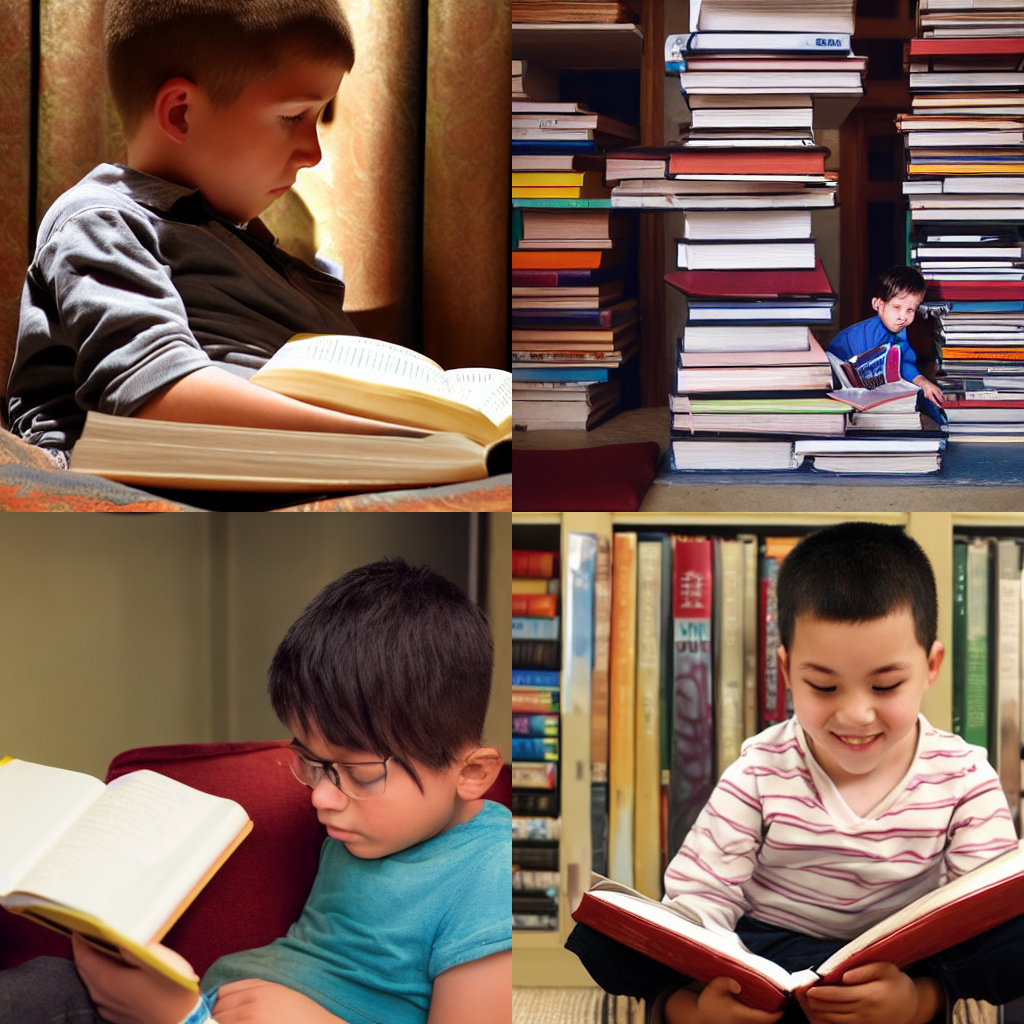

In [35]:
generator = [torch.Generator(device="cuda").manual_seed(i+1) for i in range(4)]

images = pipe(prompt=" a boy hoding a book",
              negative_prompt="",
              generator=generator,
              num_inference_steps=20,
              height=512,
              width=512,
              num_images_per_prompt=4,
              guidance_scale=7.0).images

image_grid(images, 2, 2)

With LoRA

https://qiita.com/Limitex/items/275d91dd4acdbf57b5f4

https://yuuyuublog.org/diffusers_lora/

In [27]:
import torch
from safetensors.torch import load_file

def load_safetensors_lora(pipeline, checkpoint_path, LORA_PREFIX_UNET="lora_unet", LORA_PREFIX_TEXT_ENCODER="lora_te", alpha=0.75):
    # load LoRA weight from .safetensors
    state_dict = load_file(checkpoint_path)

    visited = []

    # directly update weight in diffusers model
    for key in state_dict:
        # it is suggested to print out the key, it usually will be something like below
        # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"

        # as we have set the alpha beforehand, so just skip
        if ".alpha" in key or key in visited:
            continue

        if "text" in key:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_TEXT_ENCODER + "_")[-1].split("_")
            curr_layer = pipeline.text_encoder
        else:
            layer_infos = key.split(".")[0].split(LORA_PREFIX_UNET + "_")[-1].split("_")
            curr_layer = pipeline.unet

        # find the target layer
        temp_name = layer_infos.pop(0)
        while len(layer_infos) > -1:
            try:
                curr_layer = curr_layer.__getattr__(temp_name)
                if len(layer_infos) > 0:
                    temp_name = layer_infos.pop(0)
                elif len(layer_infos) == 0:
                    break
            except Exception:
                if len(temp_name) > 0:
                    temp_name += "_" + layer_infos.pop(0)
                else:
                    temp_name = layer_infos.pop(0)

        pair_keys = []
        if "lora_down" in key:
            pair_keys.append(key.replace("lora_down", "lora_up"))
            pair_keys.append(key)
        else:
            pair_keys.append(key)
            pair_keys.append(key.replace("lora_up", "lora_down"))

        # update weight
        if len(state_dict[pair_keys[0]].shape) == 4:
            weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
            weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
        else:
            weight_up = state_dict[pair_keys[0]].to(torch.float32)
            weight_down = state_dict[pair_keys[1]].to(torch.float32)
            curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)

        # update visited list
        for item in pair_keys:
            visited.append(item)

    return pipeline


In [32]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from diffusers.models import AutoencoderKL
import torch

#画像生成に使うモデルデータ
model_id = "runwayml/stable-diffusion-v1-5"
#画像生成に使うVAE
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
#画像生成に使うスケジューラー
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, vae=vae, custom_pipeline="lpw_stable_diffusion")

#LoRAを読み込む
pipe = load_safetensors_lora(
    pipe, 
    '/content/drive/MyDrive/my_models/canbright_satoo/satoo_with_descriptions.safetensors',
    alpha=1.0) 

pipe = pipe.to("cuda")

#NSFW規制を無効化する
if pipe.safety_checker is not None:
  pipe.safety_checker = lambda images, **kwargs: (images, False)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

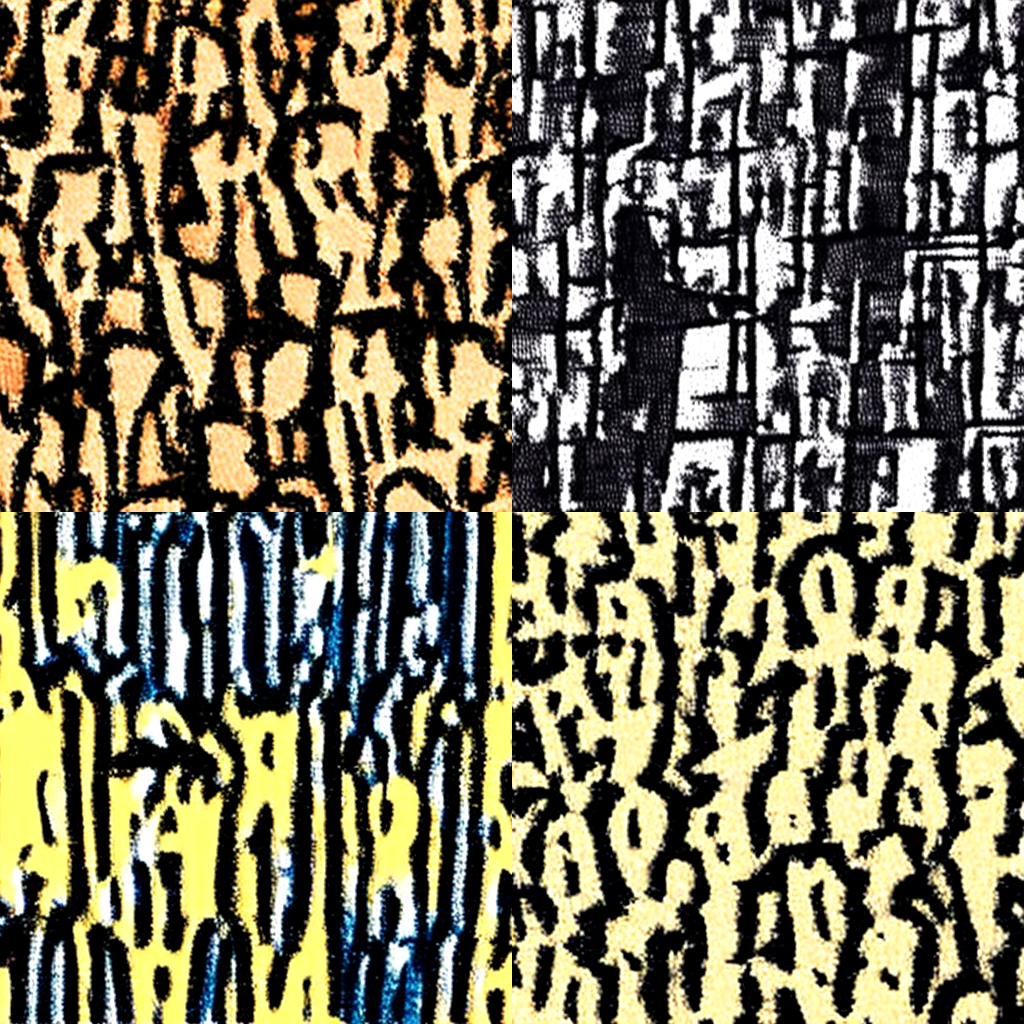

In [29]:
generator = [torch.Generator(device="cuda").manual_seed(i+1) for i in range(4)]

images = pipe(prompt=" a boy hoding a book",
              negative_prompt="",
              generator=generator,
              num_inference_steps=20,
              height=512,
              width=512,
              num_images_per_prompt=4,
              guidance_scale=12.0).images

image_grid(images, 2, 2)

In [ ]:
import datetime
import time
import torch
from diffusers import StableDiffusionPipeline
from diffusers.models import AutoencoderKL
from loadLora import load_safetensors_lora

print('model load')
load_time = time.time()
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path='YOUR MODEL PATH',
    torch_dtype=torch.float16,
    vae=AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path='stabilityai/sd-vae-ft-ema', 
        torch_dtype=torch.float16
    ),
)

pipe = load_safetensors_lora(
    pipe, 
    'YOUR SAFETENSORS LORA PATH'
).to("cuda")

pipe.safety_checker = None if pipe.safety_checker is None else lambda images, **kwargs: (images, False)
pipe.enable_attention_slicing()
time_load = time.time() - load_time
print(f"Models loaded in {time_load:.2f}s")

image = pipe(
    prompt='YOUR PROMPT',
    height=768,
    width=512,
    num_inference_steps=28,
    guidance_scale=12.0,
    negative_prompt='YOUR PROMPT'
).images[0]

image.save("images/" + str(datetime.datetime.now().strftime('%Y%m%d%H%M%S%f')) + ".png")
